In [1]:
%pip install tf_keras_vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.6 MB/s eta 0:00:00


# Create your dataset

1) Choose which classes you would like to add.

2) Create a dataset with your own photos

3) Separate your dataset into train and test subsets.

In [2]:
import os
import pandas as pd
from glob import glob

def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])

    return pd.DataFrame(data, columns = ["path", "label"])

In [3]:
# If you're using Google Colab, you need to upload your data to Google Drive.
# Then, run the following code to mount your Google Drive and access your files in Colab.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ToDo: Provide the path to the training and testing dataset directories

train_df = create_dataframe_from_directories("/content/drive/MyDrive/ARN/train")
test_df = create_dataframe_from_directories("/content/drive/MyDrive/ARN/test")

In [5]:
LABEL_NAMES = pd.unique(train_df['label'])
LABEL_NAMES

array(['Basketball', 'Rugby', 'Tennis', 'Football'], dtype=object)

**TODO**: Display some images of your dataset

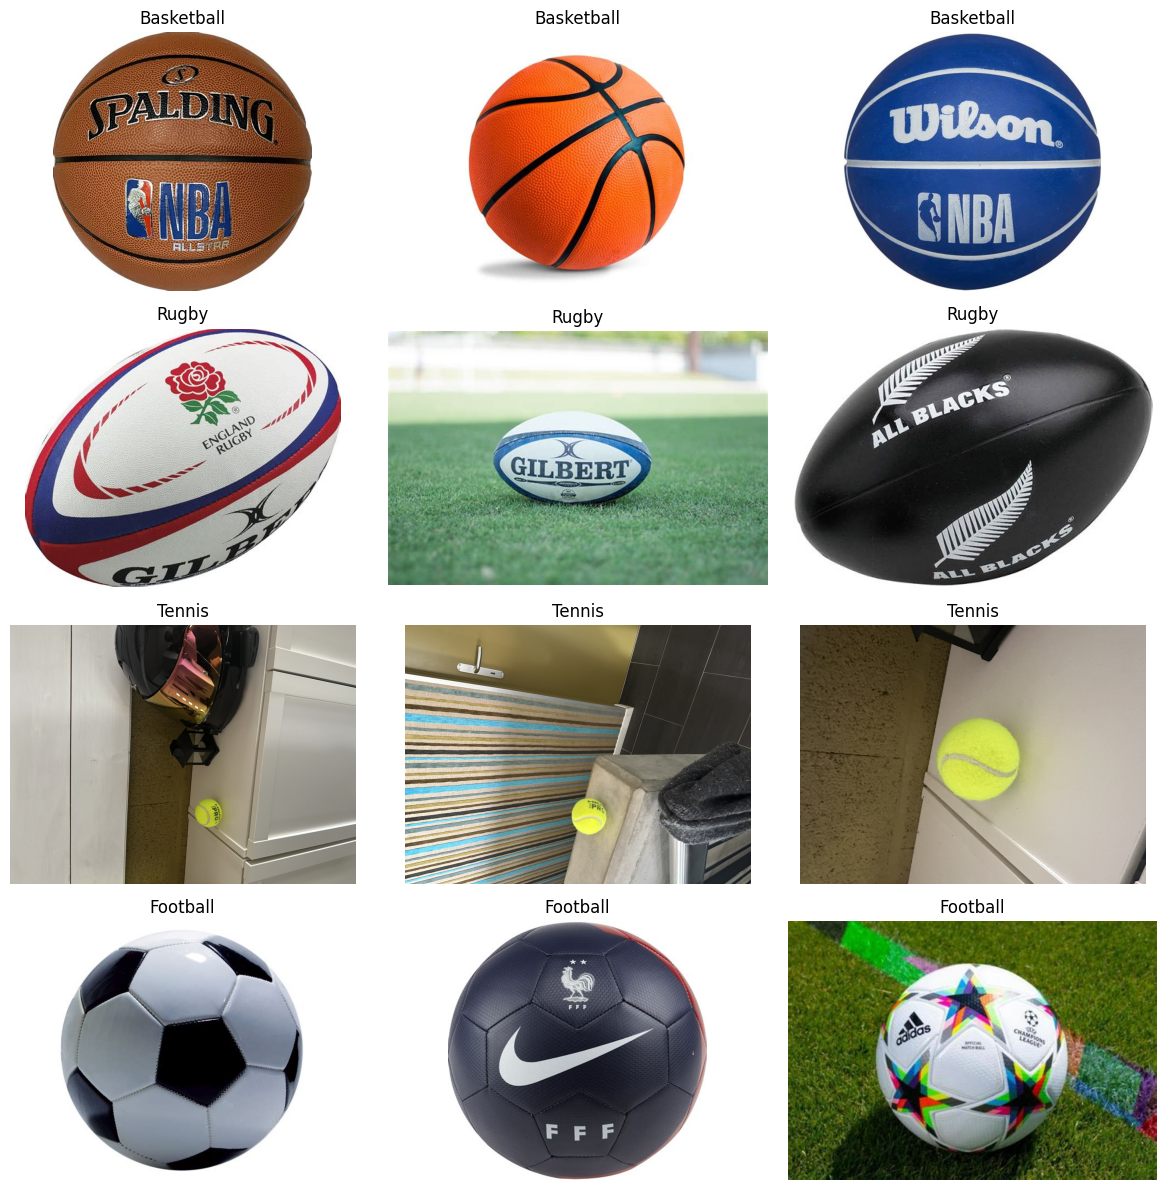

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

# Afficher 3 images par classe
fig, axes = plt.subplots(len(LABEL_NAMES), 3, figsize=(12, len(LABEL_NAMES) * 3))

for i, label in enumerate(LABEL_NAMES):
    # Prendre les 3 premières images de chaque classe
    class_images = train_df[train_df['label'] == label].head(3)

    for j, (_, row) in enumerate(class_images.iterrows()):
        img = Image.open(row['path'])
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{label}")
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Explore your dataset

**TODO**: count the number of examples per classes and plot an histogram of it

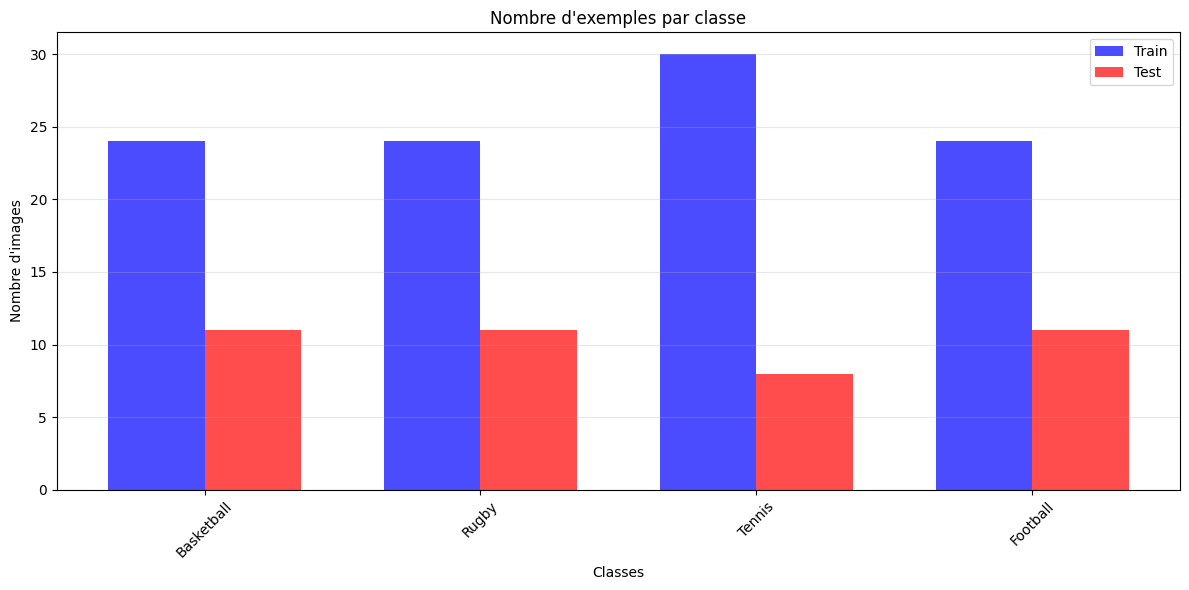

In [7]:
import matplotlib.pyplot as plt

# Compter le nombre d'exemples par classe pour train et test
train_counts = train_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Créer un histogramme combiné
plt.figure(figsize=(12, 6))

# Créer les positions des barres
x = range(len(LABEL_NAMES))
width = 0.35

# Tracer les barres pour train et test
plt.bar([i - width/2 for i in x], [train_counts[label] for label in LABEL_NAMES],
        width, label='Train', color='blue', alpha=0.7)
plt.bar([i + width/2 for i in x], [test_counts[label] for label in LABEL_NAMES],
        width, label='Test', color='red', alpha=0.7)

# Personnaliser le graphique
plt.xlabel('Classes')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'exemples par classe')
plt.xticks(x, LABEL_NAMES, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Preprocessing steps

In [16]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness,
    RandomContrast, RandomTranslation
)

from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

# TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
# Ajout des couches d'augmentation d'images
image_augmentations = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomTranslation(0.2, 0.2)
])


def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        opened_img = image_preprocesses(np.asarray(image))

    return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

**TODO**: plot examples of preprocessed and augmented images

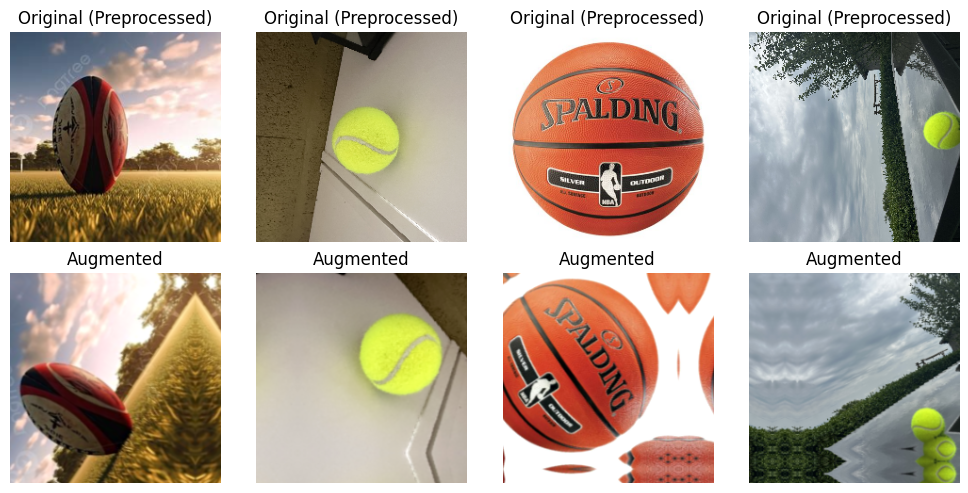

In [17]:
# TODO: plot examples of preprocessed and augmented images

import numpy as np
import PIL

# Get a few sample image paths
sample_image_paths = train_df['path'].sample(4).tolist()

# Open and preprocess the original images
original_images = open_images(sample_image_paths)

# Augment the preprocessed images
augmented_images = augment_images(original_images)

# Plotting
plt.figure(figsize=(10, 5))

for i in range(len(sample_image_paths)):
    # Plot original preprocessed image
    plt.subplot(2, len(sample_image_paths), i + 1)
    plt.imshow(original_images[i])
    plt.title("Original (Preprocessed)")
    plt.axis('off')

    # Plot augmented image
    plt.subplot(2, len(sample_image_paths), len(sample_image_paths) + i + 1)
    plt.imshow(augmented_images[i])
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Define model

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout,
    BatchNormalization
)

def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )

    layers = base_model.output

    added_layers = [
        # Réduction spatiale par Global Average Pooling (utile pour les CAMs et réduit le surapprentissage)
        GlobalAveragePooling2D(),

        # Bloc Dense 1 : Extraction de caractéristiques avec régularisation
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),  # Fort dropout pour éviter l'overfitting sur cette couche large

        # Bloc Dense 2 : Raffinement des représentations apprises
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),  # Dropout modéré pour garder un bon compromis entre régularisation et apprentissage

        # Couche de sortie : classification en 4 catégories sportives
        Dense(4, activation='softmax', name='predictions')  # Classes : tennis, basket, foot, rugby
    ]


    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )

    return model

In [22]:
get_model().summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,620,868 (10.00 MB)

 Trainable params: 362,116 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time

In [23]:
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

In [24]:
def open_images(paths):
    images = []
    for path in paths:
        with PIL.Image.open(path).convert('RGB') as image:
            images.append(image_preprocesses(np.asarray(image)))

    return np.stack(images)

In [39]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

shuffled_dataset = train_df.sample(frac=1, random_state=1234).reset_index(drop=True)

dataset_paths = shuffled_dataset['path'].to_numpy()
dataset_labels = shuffled_dataset['label'].to_numpy()

total_train_paths, test_paths, total_train_labels, test_labels = train_test_split(
    dataset_paths, dataset_labels, test_size=0.2, random_state=1234
)

# We need to convert from string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(dataset_labels)
total_train_labels = label_encoder.transform(total_train_labels)
test_labels = label_encoder.transform(test_labels)

NB_EPOCHS = 15

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
models = []
histories = []

for fold_idx, (train_index, val_index) in enumerate(KFold(n_splits=10).split(total_train_paths, total_train_labels)):
    print(f"Training fold {fold_idx + 1}/10")

    train_images = open_images(total_train_paths[train_index])
    train_labels = total_train_labels[train_index]

    val_images = open_images(total_train_paths[val_index])
    val_labels = total_train_labels[val_index]

    model = get_model() # We reinitialize the model

    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=32,
        validation_data=[val_images, val_labels],
        epochs=NB_EPOCHS,
    )

    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

    # AJOUT: Sauvegarde du modèle et de l'historique
    models.append(model)
    histories.append(history)

    print(f"Fold {fold_idx + 1} - Final val_accuracy: {history.history['val_acc'][-1]:.4f}")

Training fold 1/10
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - acc: 0.4180 - loss: 2.1671 - val_acc: 0.4444 - val_loss: 1.6325
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - acc: 0.9145 - loss: 0.7771 - val_acc: 0.5556 - val_loss: 1.5158
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 627ms/step - acc: 0.9891 - loss: 0.7171 - val_acc: 0.5556 - val_loss: 1.3998
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step - acc: 1.0000 - loss: 0.6405 - val_acc: 0.6667 - val_loss: 1.3408
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 616ms/step - acc: 1.0000 - loss: 0.6273 - val_acc: 0.6667 - val_loss: 1.3410
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step - acc: 1.0000 - loss: 0.6376 - val_acc: 0.6667 - val_loss: 1.2847
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step - acc: 1.0000 - loss: 0.6010 - val_acc: 0.6667 - val_loss: 1.3214
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 585ms/step - acc: 1.0000 - loss: 0.5964 - val_acc: 0.6667 - val_loss: 1.3370
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 623ms/step - acc:

In [40]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)

    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='green', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='green', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()

# Results

**TODO**: plot the results from your crossvalidation

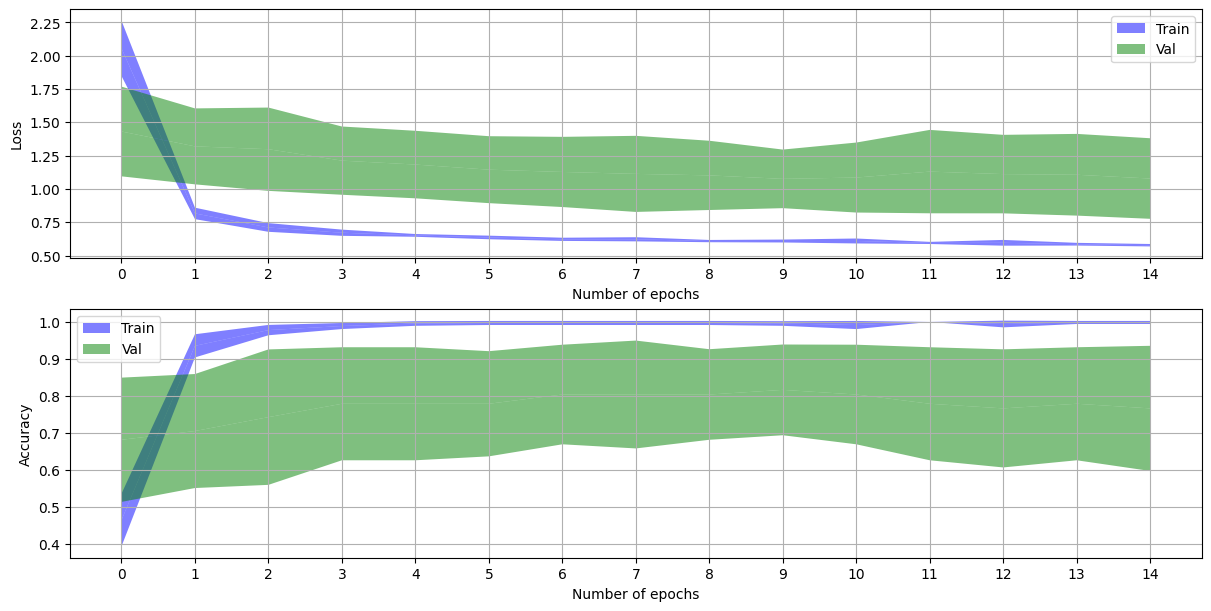

In [41]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

=== Validation scores des folds ===
Fold 1 - Validation Accuracy: 0.6667
Fold 2 - Validation Accuracy: 0.7500
Fold 3 - Validation Accuracy: 0.8750
Fold 4 - Validation Accuracy: 0.8750
Fold 5 - Validation Accuracy: 1.0000
Fold 6 - Validation Accuracy: 1.0000
Fold 7 - Validation Accuracy: 0.7500
Fold 8 - Validation Accuracy: 0.5000
Fold 9 - Validation Accuracy: 0.7500
Fold 10 - Validation Accuracy: 0.5000

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


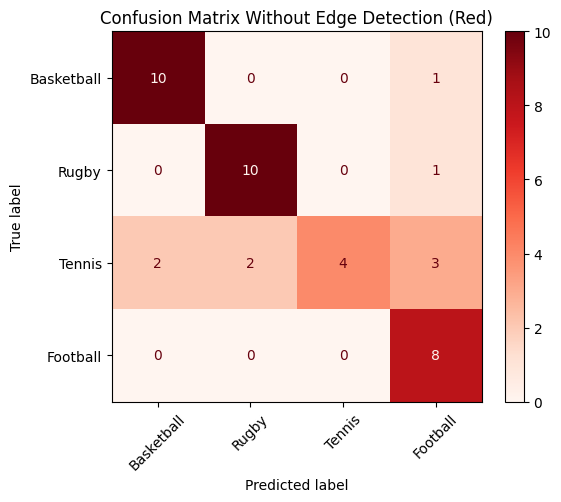

=== Classification Report Without Edge Detection ===
              precision    recall  f1-score   support

  Basketball      0.833     0.909     0.870        11
       Rugby      0.833     0.909     0.870        11
      Tennis      1.000     0.364     0.533        11
    Football      0.615     1.000     0.762         8

    accuracy                          0.780        41
   macro avg      0.821     0.795     0.759        41
weighted avg      0.836     0.780     0.758        41

Global Accuracy Without Edge Detection: 0.7805

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


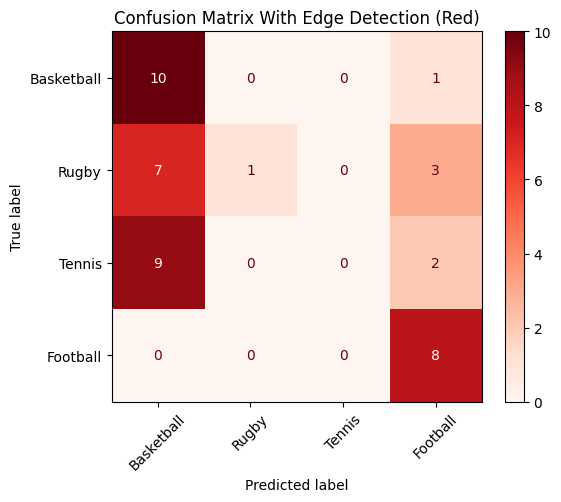

=== Classification Report With Edge Detection ===
              precision    recall  f1-score   support

  Basketball      0.385     0.909     0.541        11
       Rugby      1.000     0.091     0.167        11
      Tennis      0.000     0.000     0.000        11
    Football      0.571     1.000     0.727         8

    accuracy                          0.463        41
   macro avg      0.489     0.500     0.359        41
weighted avg      0.483     0.463     0.332        41

Global Accuracy With Edge Detection: 0.4634


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as me
from matplotlib import rcParams

rcParams.update({'figure.autolayout': True})

# Préparer les données
total_test_paths = test_df['path'].to_numpy()
total_test_labels = label_encoder.transform(test_df['label'].to_numpy()).astype(int)

# Fonction d'évaluation
def evaluate_model(model, use_edge_detection=False):
    if use_edge_detection:
        test_images = open_images_with_edge_detection(total_test_paths)
    else:
        test_images = open_images_without_edge_detection(total_test_paths)

    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=-1).astype(int)

    cm = me.confusion_matrix(total_test_labels, predicted_labels, labels=np.arange(len(LABEL_NAMES)))
    report = me.classification_report(total_test_labels, predicted_labels, target_names=LABEL_NAMES, digits=3)
    acc = me.accuracy_score(total_test_labels, predicted_labels)
    return cm, predicted_labels, report, acc

# Affichage de la matrice de confusion avec échelle
def plot_confusion_matrix(confusion_matrix, title):
    fig, ax = plt.subplots(figsize=(6, 5))  # Format compact
    disp = me.ConfusionMatrixDisplay(confusion_matrix, display_labels=LABEL_NAMES)
    disp.plot(ax=ax, cmap='Reds', xticks_rotation=45, colorbar=True)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Affichage des scores des folds
def print_fold_scores(histories):
    print("=== Validation scores des folds ===")
    for i, h in enumerate(histories):
        val_acc = h.history.get('val_accuracy') or h.history.get('val_acc')
        if val_acc:
            print(f"Fold {i + 1} - Validation Accuracy: {val_acc[-1]:.4f}")
    print()

# Sélection du meilleur modèle
val_accuracies = [h.history.get('val_accuracy', h.history['val_acc'])[-1] for h in histories]
best_model_index = np.argmax(val_accuracies)
best_model = models[best_model_index]

# Afficher les scores des folds
print_fold_scores(histories)

# Test sans edge detection
cm_no_edge, _, report_no_edge, acc_no_edge = evaluate_model(best_model, use_edge_detection=False)
plot_confusion_matrix(cm_no_edge, "Confusion Matrix Without Edge Detection (Red)")
print("=== Classification Report Without Edge Detection ===")
print(report_no_edge)
print(f"Global Accuracy Without Edge Detection: {acc_no_edge:.4f}\n")

# Test avec edge detection
cm_edge, _, report_edge, acc_edge = evaluate_model(best_model, use_edge_detection=True)
plot_confusion_matrix(cm_edge, "Confusion Matrix With Edge Detection (Red)")
print("=== Classification Report With Edge Detection ===")
print(report_edge)
print(f"Global Accuracy With Edge Detection: {acc_edge:.4f}")


### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 10

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)

    i = 0
    for _, rowdata in train_df[train_df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it